# Hello BERT

<a href="https://colab.research.google.com/drive/1n8fd41Bi8yaWp0__eVCe9T4ctWVwSxvC?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

## Using BERT for Text Classifciation
In this example, we are going to use BERT for the sentiment analysis task.

**Dataset**: download SST2 dataset for Sentiment Classification

1- Baseline bidirectional LSTM **(70%)**

2- Use BERT as feature extractor [CLS] **(82%)**

3- Use BERT as feature extractor (sequence representation) **(85%)**

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.4 MB/s eta 0:00:00


In [4]:
# generic imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Transformers
import torch
import transformers as ppb

# Baseline
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [5]:
# download SST2 dataset for Sentiment Classification
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
df = df[:2000]
print(df.shape)
df.head(10)

(2000, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
5,campanella gets the tone just right funny in t...,1
6,a fan film that for the uninitiated plays bett...,0
7,"b art and berling are both superb , while hupp...",1
8,"a little less extreme than in the past , with ...",0
9,the film is strictly routine,0


## LSTM Baseline

In [7]:
# data tokenization, padding and splitting
voc_size = 1000
tokenizer = Tokenizer(num_words=voc_size, lower=True, char_level=False)
tokenizer.fit_on_texts(df[0].values)
X = tokenizer.texts_to_sequences(df[0].values)
X = pad_sequences(X, maxlen=100)
y = keras.utils.to_categorical(df[1].values,num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 100) (400, 100) (1600, 2) (400, 2)


In [8]:
# LSTM model
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(voc_size, 8)(inputs)
# x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
encoded = layers.Bidirectional(layers.LSTM(16))(x)
x = layers.Dropout(0.5)(encoded)
outputs = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 8)           8000      
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3200      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 11,266
Trainable params: 11,266
Non-trainable params: 0
_________________________________________________________

In [9]:
model.compile("rmsprop", "categorical_crossentropy", metrics=["accuracy"])

In [10]:
# used for latent space visalization
encoder = keras.Model(inputs, encoded)

In [11]:
# train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
13/13 [==============================] - 12s 219ms/step - loss: 0.6929 - accuracy: 0.5250 - val_loss: 0.6939 - val_accuracy: 0.4925
Epoch 2/15
13/13 [==============================] - 3s 220ms/step - loss: 0.6921 - accuracy: 0.5281 - val_loss: 0.6940 - val_accuracy: 0.4925
Epoch 3/15
13/13 [==============================] - 2s 151ms/step - loss: 0.6900 - accuracy: 0.5281 - val_loss: 0.6952 - val_accuracy: 0.4925
Epoch 4/15
13/13 [==============================] - 1s 100ms/step - loss: 0.6884 - accuracy: 0.5275 - val_loss: 0.6947 - val_accuracy: 0.4925
Epoch 5/15
13/13 [==============================] - 2s 124ms/step - loss: 0.6875 - accuracy: 0.5300 - val_loss: 0.6934 - val_accuracy: 0.4925
Epoch 6/15
13/13 [==============================] - 1s 53ms/step - loss: 0.6851 - accuracy: 0.5369 - val_loss: 0.6920 - val_accuracy: 0.4950
Epoch 7/15
13/13 [==============================] - 1s 55ms/step - loss: 0.6810 - accuracy: 0.5481 - val_loss: 0.6876 - val_accuracy: 0.5250
Epoch 8

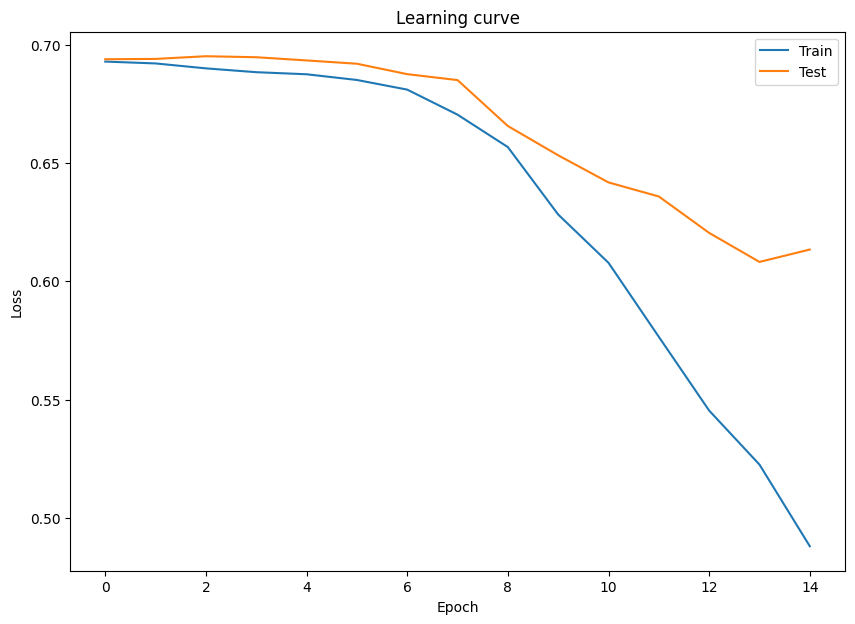

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')

plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

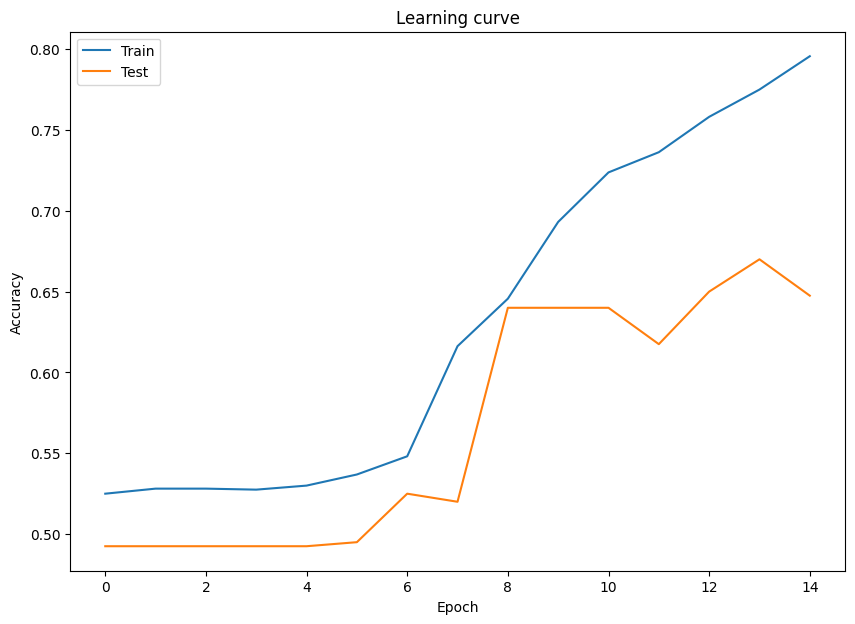

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')

plt.title('Learning curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()

13/13 [==============================] - 1s 5ms/step


<Axes: >

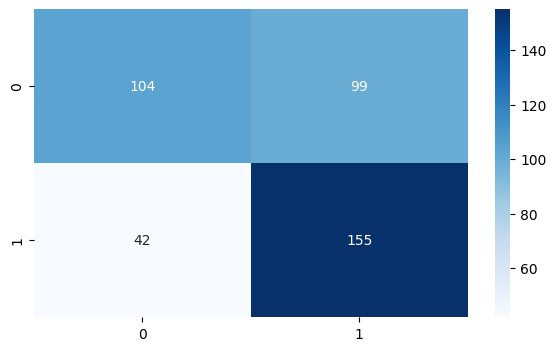

In [14]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize = (7,4))
sns.heatmap(cm, fmt='g', annot=True, cmap='Blues')

In [15]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.51      0.60       203
           1       0.61      0.79      0.69       197

    accuracy                           0.65       400
   macro avg       0.66      0.65      0.64       400
weighted avg       0.66      0.65      0.64       400



50/50 [==============================] - 1s 5ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.032839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.803650
[t-SNE] KL divergence after 1000 iterations: 0.533885


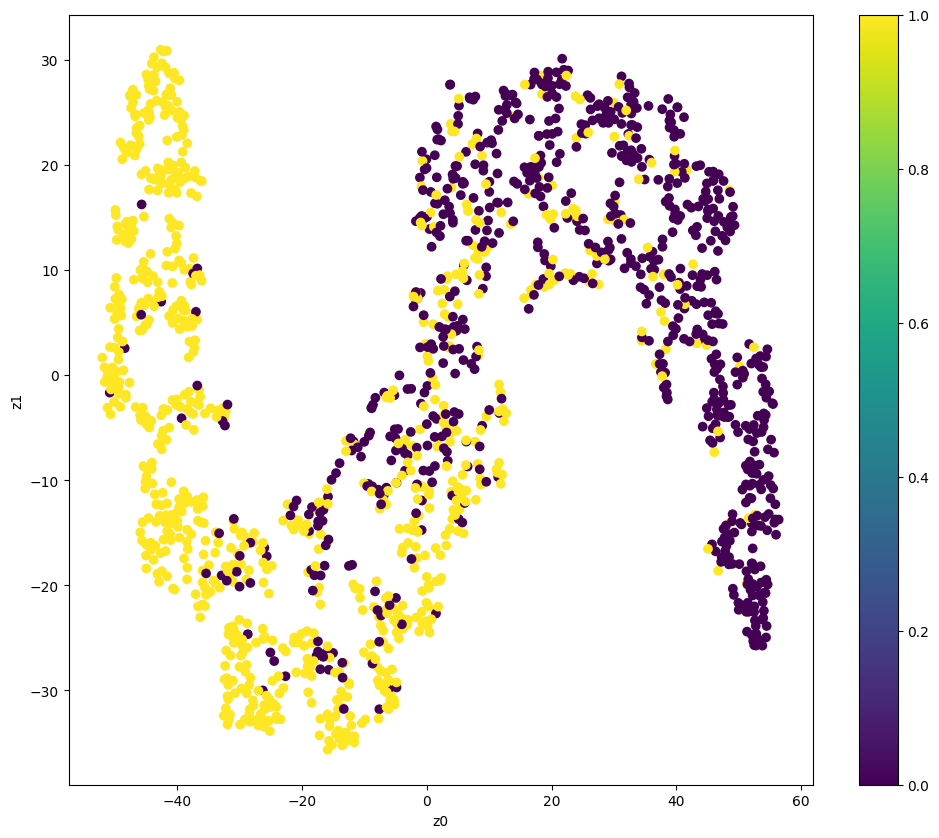

In [16]:
encoded_codes = encoder.predict(X_train)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_train, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()

13/13 [==============================] - 1s 5ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.055906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.191040
[t-SNE] KL divergence after 1000 iterations: 0.259464


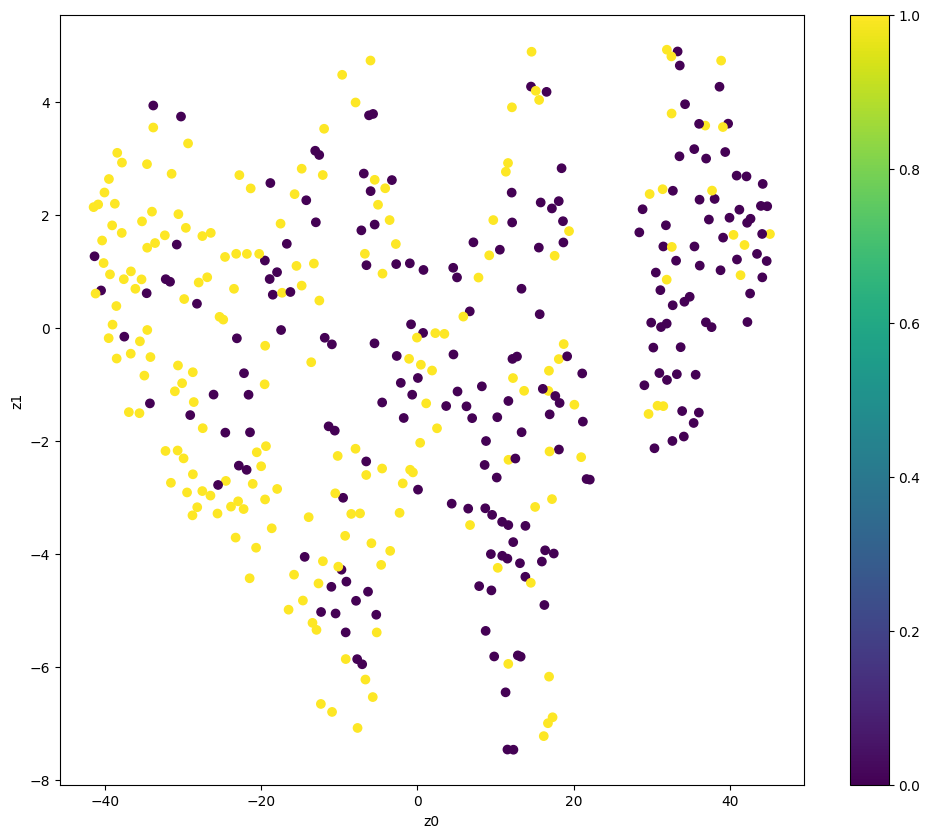

In [17]:
encoded_codes = encoder.predict(X_test)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_test, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()

## BERT

In [18]:
# BERT and tokenizer
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Data preparation:
# 1) split words into tokens
# 2) pad sequences
# 3) add [CLS] at start and [SEP] at end
# 4) convert tokens to ids
# now the data is ready for the BERT model

tokenized = df[0].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(np.array(padded).shape)
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(2000, 59)
(2000, 59)


In [20]:
# feed the data to the BERT model and get the last layer hidden states
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = bert_model(input_ids, attention_mask=attention_mask)

In [21]:
print(last_hidden_states[0].numpy().shape)
X_bert = last_hidden_states[0][:,0,:].numpy() # the CLS output
X_bert.shape

(2000, 59, 768)


(2000, 768)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 768) (400, 768) (1600, 2) (400, 2)


In [23]:
# samll model that takes the CLS as input
s_input = keras.Input(shape=(X_bert.shape[1],), dtype='float32')
s_encoded = layers.Dense(32)(s_input)
s_ouput = layers.Dense(2, activation='softmax')(s_encoded)
s_model = keras.Model(s_input, s_ouput)
s_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                24608     
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 24,674
Trainable params: 24,674
Non-trainable params: 0
_________________________________________________________________


In [24]:
s_model.compile("rmsprop", "categorical_crossentropy", metrics=["accuracy"])

In [25]:
# used for latent space visalization
s_encoder = keras.Model(s_input, s_encoded)
s_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                24608     
                                                                 
Total params: 24,608
Trainable params: 24,608
Non-trainable params: 0
_________________________________________________________________


In [26]:
# train the small model on the CLS output of BERT
history = s_model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
13/13 [==============================] - 1s 17ms/step - loss: 0.6323 - accuracy: 0.6681 - val_loss: 0.5493 - val_accuracy: 0.7075
Epoch 2/25
13/13 [==============================] - 0s 6ms/step - loss: 0.4551 - accuracy: 0.7944 - val_loss: 0.5257 - val_accuracy: 0.7300
Epoch 3/25
13/13 [==============================] - 0s 6ms/step - loss: 0.4300 - accuracy: 0.8012 - val_loss: 0.4026 - val_accuracy: 0.8150
Epoch 4/25
13/13 [==============================] - 0s 6ms/step - loss: 0.3922 - accuracy: 0.8213 - val_loss: 0.4157 - val_accuracy: 0.7950
Epoch 5/25
13/13 [==============================] - 0s 6ms/step - loss: 0.3780 - accuracy: 0.8331 - val_loss: 0.3730 - val_accuracy: 0.8325
Epoch 6/25
13/13 [==============================] - 0s 7ms/step - loss: 0.3713 - accuracy: 0.8331 - val_loss: 0.3716 - val_accuracy: 0.8425
Epoch 7/25
13/13 [==============================] - 0s 6ms/step - loss: 0.3470 - accuracy: 0.8431 - val_loss: 0.3640 - val_accuracy: 0.8400
Epoch 8/25
13/13 [=

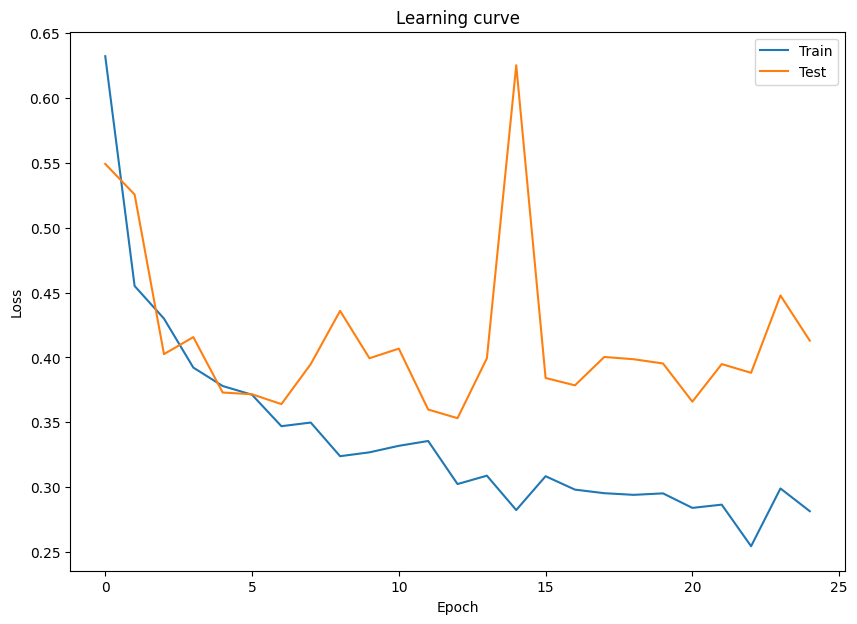

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')

plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

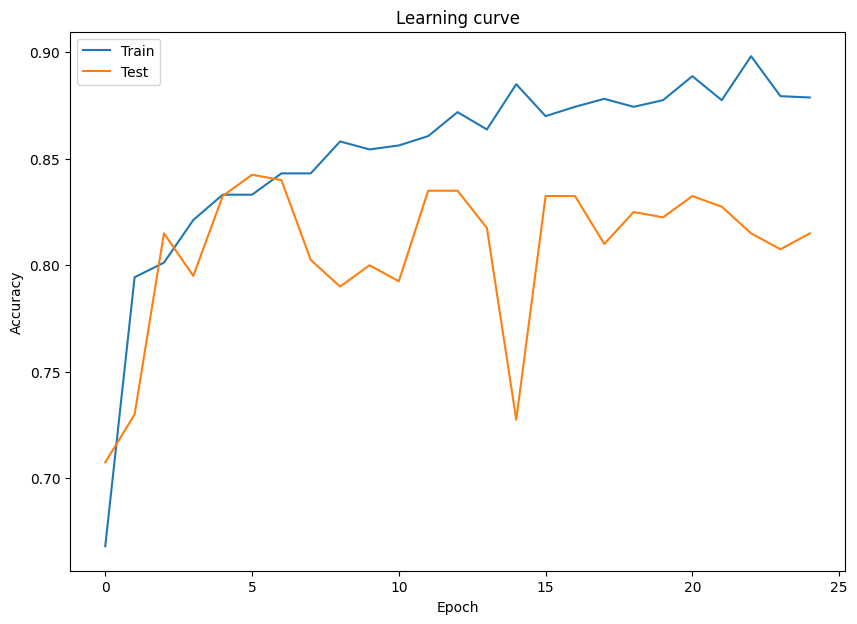

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')

plt.title('Learning curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()


13/13 [==============================] - 0s 2ms/step


<Axes: >

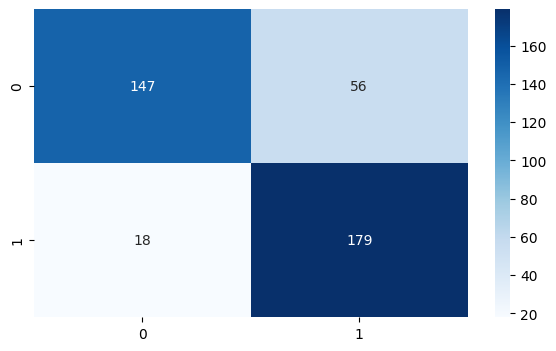

In [29]:
y_pred = s_model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize = (7,4))
sns.heatmap(cm, fmt='g', annot=True, cmap='Blues')

In [30]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       203
           1       0.76      0.91      0.83       197

    accuracy                           0.81       400
   macro avg       0.83      0.82      0.81       400
weighted avg       0.83      0.81      0.81       400



50/50 [==============================] - 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.607266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.066711
[t-SNE] KL divergence after 1000 iterations: 1.550358


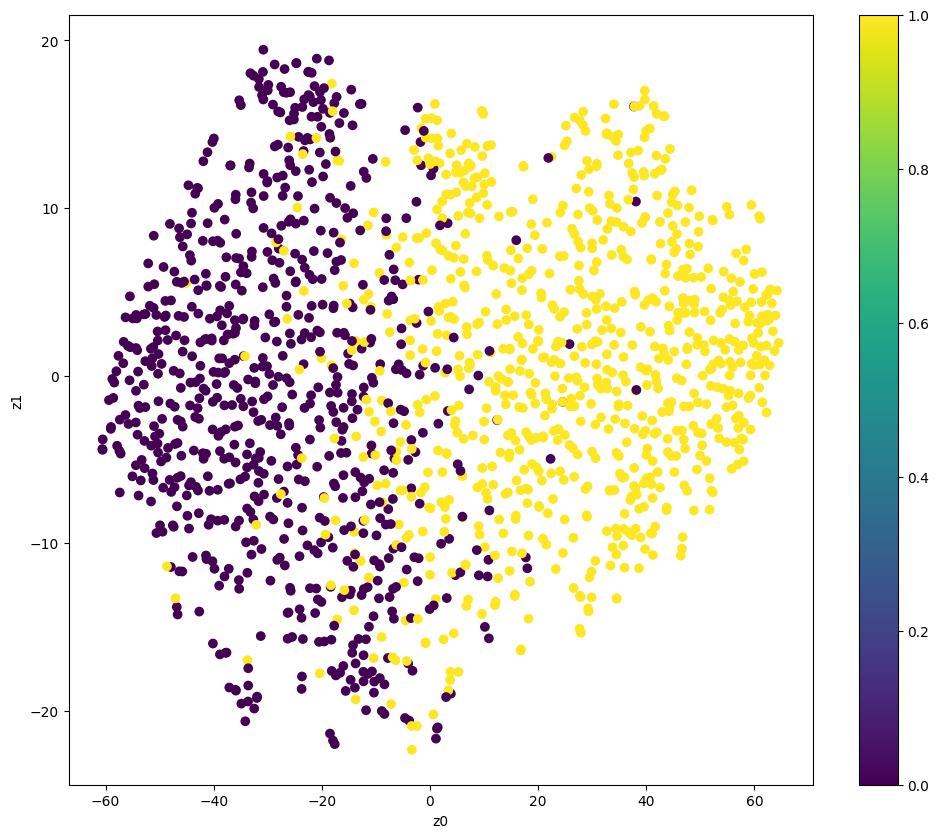

In [31]:
encoded_codes = s_encoder.predict(X_train)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_train, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()


13/13 [==============================] - 0s 2ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.754026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.134903
[t-SNE] KL divergence after 1000 iterations: 0.817940


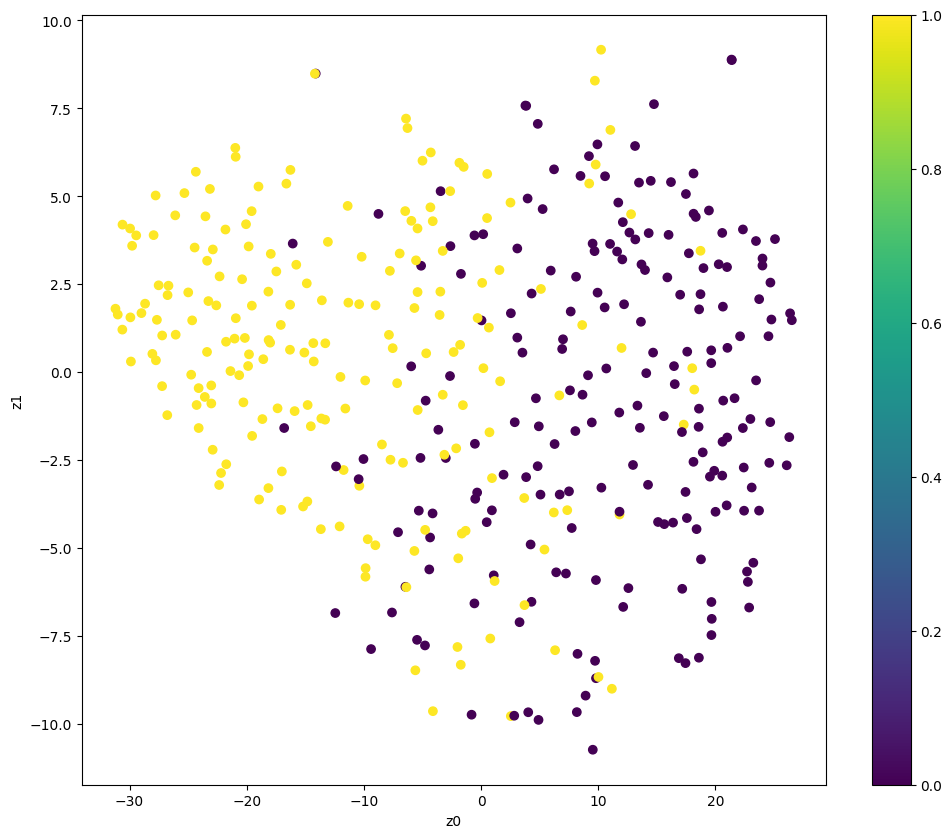

In [32]:
encoded_codes = s_encoder.predict(X_test)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_test, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()

## BERT the whole sequence

In [33]:
X_seq_bert = last_hidden_states[0][:,1:,:].numpy() # (samples, seq, feat)
X_seq_bert.shape

(2000, 58, 768)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_bert, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 58, 768) (400, 58, 768) (1600, 2) (400, 2)


In [35]:
inputs = keras.Input(shape=(None,X_bert.shape[1]), dtype="float32")
encoded = layers.Bidirectional(layers.LSTM(16))(inputs)
x = layers.Dropout(0.1)(encoded)
outputs = layers.Dense(2, activation="softmax")(x)
bs_model = keras.Model(inputs, outputs)
bs_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               100480    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 100,546
Trainable params: 100,546
Non-trainable params: 0
_________________________________________________________________


In [36]:
bs_model.compile("rmsprop", "categorical_crossentropy", metrics=["accuracy"])

In [37]:
encoder = keras.Model(inputs, encoded)
encoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               100480    
 nal)                                                            
                                                                 
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = bs_model.fit(X_train, y_train, batch_size=128, epochs=12, validation_data=(X_test, y_test))

Epoch 1/12
13/13 [==============================] - 5s 102ms/step - loss: 0.5829 - accuracy: 0.6675 - val_loss: 0.4580 - val_accuracy: 0.7750
Epoch 2/12
13/13 [==============================] - 0s 29ms/step - loss: 0.4166 - accuracy: 0.8131 - val_loss: 0.3835 - val_accuracy: 0.8450
Epoch 3/12
13/13 [==============================] - 0s 28ms/step - loss: 0.3545 - accuracy: 0.8400 - val_loss: 0.3856 - val_accuracy: 0.8400
Epoch 4/12
13/13 [==============================] - 0s 28ms/step - loss: 0.2911 - accuracy: 0.8756 - val_loss: 0.4986 - val_accuracy: 0.7575
Epoch 5/12
13/13 [==============================] - 0s 28ms/step - loss: 0.2803 - accuracy: 0.8819 - val_loss: 0.3598 - val_accuracy: 0.8475
Epoch 6/12
13/13 [==============================] - 0s 28ms/step - loss: 0.2334 - accuracy: 0.9081 - val_loss: 0.4188 - val_accuracy: 0.8150
Epoch 7/12
13/13 [==============================] - 0s 28ms/step - loss: 0.2230 - accuracy: 0.9181 - val_loss: 0.3845 - val_accuracy: 0.8375
Epoch 8/12
1

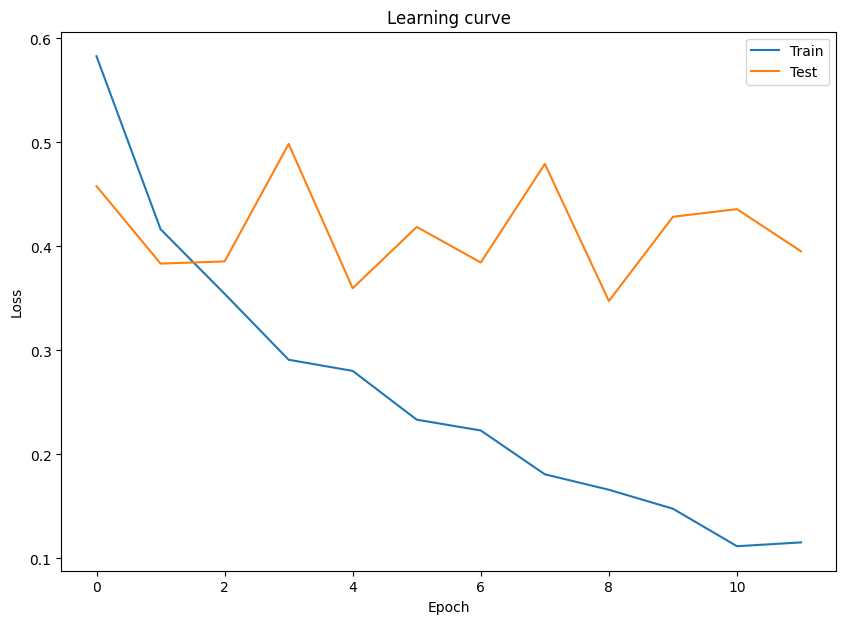

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')

plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

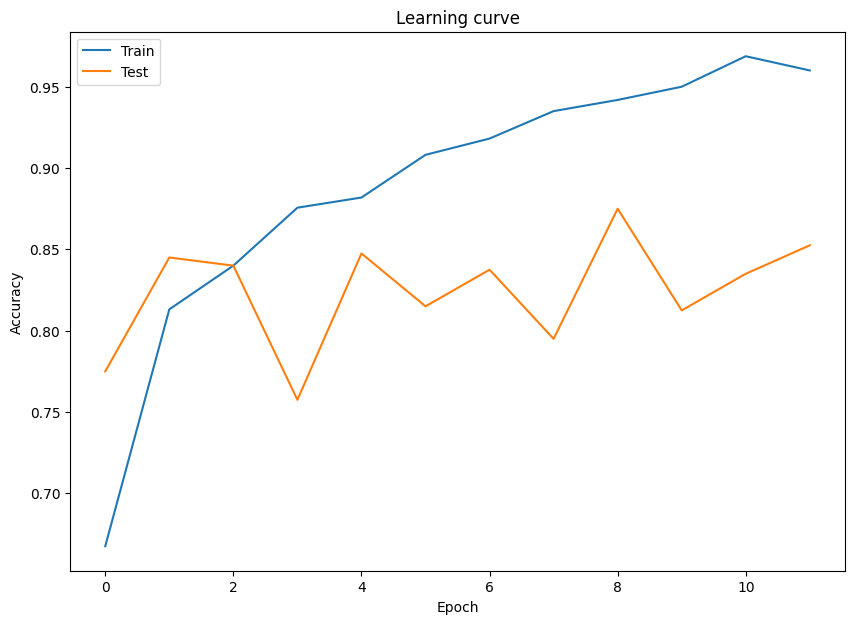

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')

plt.title('Learning curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()

13/13 [==============================] - 1s 7ms/step


<Axes: >

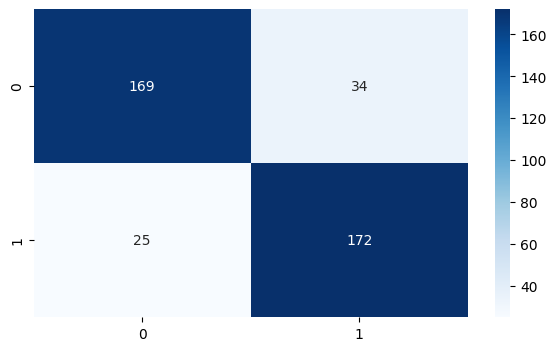

In [41]:
y_pred = bs_model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize = (7,4))
sns.heatmap(cm, fmt='g', annot=True, cmap='Blues')

In [42]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       203
           1       0.83      0.87      0.85       197

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



50/50 [==============================] - 1s 5ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.727758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.554016
[t-SNE] KL divergence after 1000 iterations: 1.413086


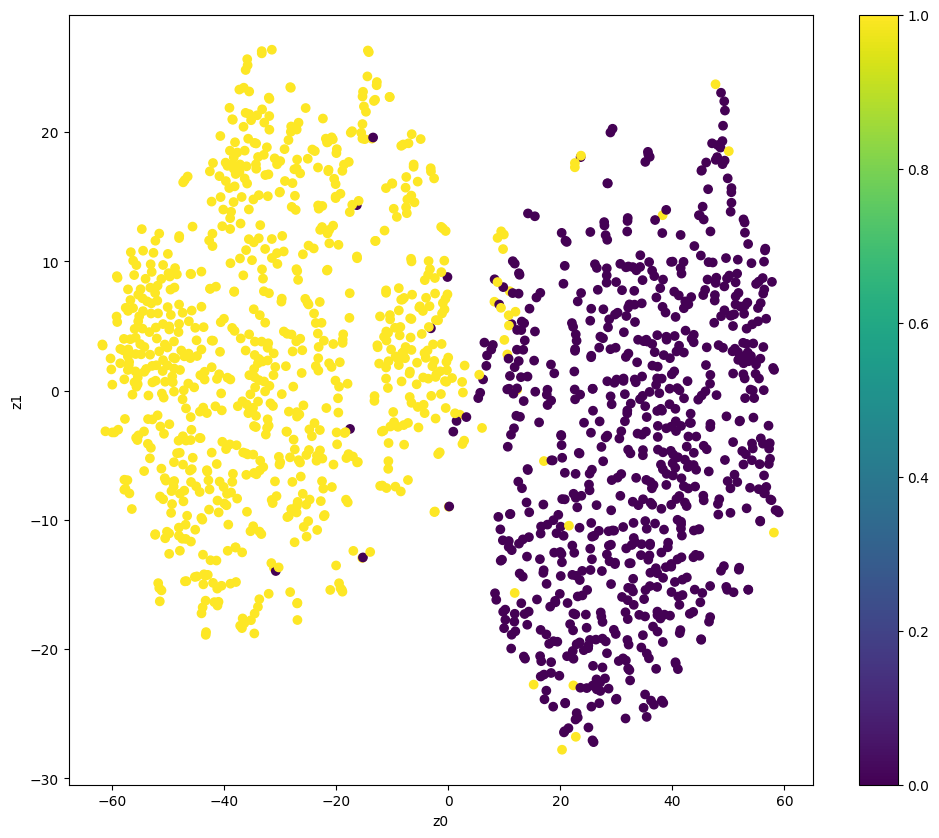

In [43]:
encoded_codes = encoder.predict(X_train)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_train, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()

13/13 [==============================] - 1s 9ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.979271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.770683
[t-SNE] KL divergence after 1000 iterations: 0.873405


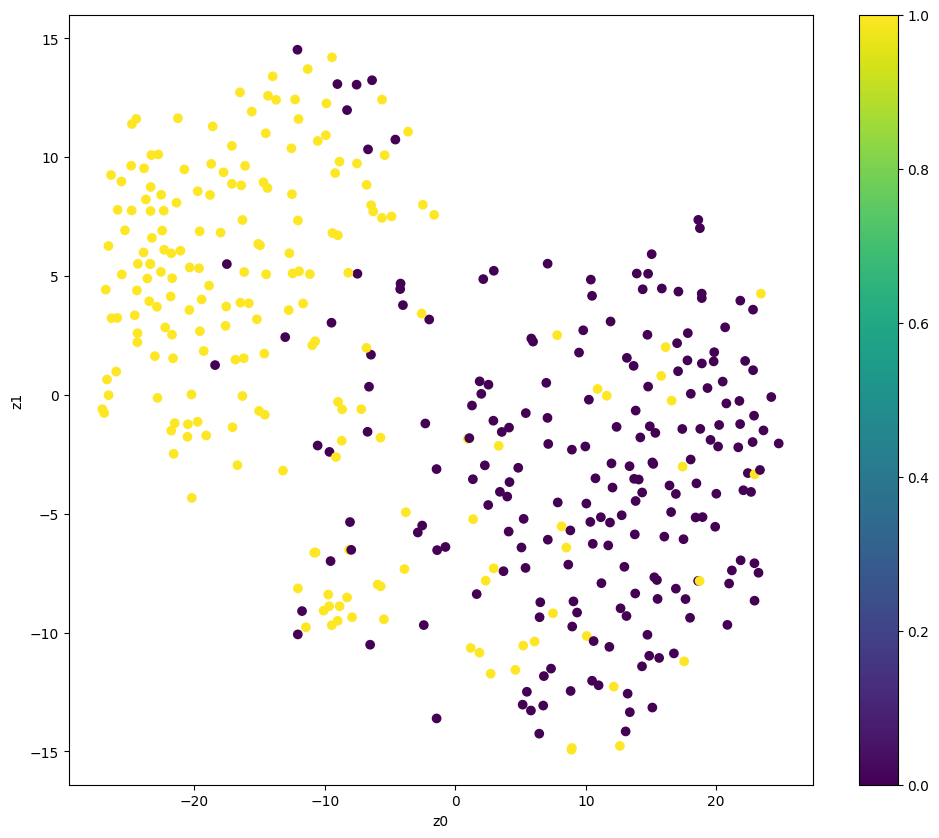

In [44]:
encoded_codes = encoder.predict(X_test)
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(encoded_codes)
plt.figure(figsize=(12, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.argmax(y_test, axis=1))
plt.colorbar()
plt.xlabel("z0")
plt.ylabel("z1")
plt.show()